# Differential Learning
(Dario Izzo)

## 1 - Importing stuff


In [91]:
from pyaudi import gdual, sin, cos, tan
from random import random
from matplotlib import pyplot as plt
%matplotlib inline

## 2 - Controller representation and "simulator"
The controller is tipycally represented by a neural net, but for the purpose of explaining this new learning concept we will just use polinomials. Later, changing the controllers into a NN with weights as params will not change the essence of what is done here.

In [92]:
# Definition of the controller in terms of the weights parameters
def u(state, weights):
    x,v = state
    a,b,c,e,f,g = weights
    return a + b*x + c*v + e*x*v + f*x**2 + g*v**2

In [93]:
# Definition of the equation of motion (our physics simulator propagating the system to its next state)
def eom(state, weights):
    x,v = state
    dx = v
    dv = u(state, weights)
    return (dx, dv)

## 3 - The Euler Propagation
In ER Euler propagators are commonly used. The essence of what is done here would not change the if we code a Newton Raphson or a better method.

In [94]:
weights = [gdual(0.2*(random()-0.5), _, 3) for _ in "abcefg"]
x = [gdual(2*(random()-0.5))]
v = [gdual(2*(random()-0.5))]
dt = 0.1
# We propagate for 10 seconds (cannot oincrease this much as the control is polynomial thus x**2 and v**2 would make u1 biiiig)
for i in range(100):
    dx, dv = eom([x[-1],v[-1]], weights)
    x.append(x[-1] + dt * dx)
    v.append(v[-1] + dt * dv)

NOTE: the resulting points are gdual, they contain information on how the state reached by our "robot" changes if we change the control weights!!

In [95]:
x[0], x[-1]

(-0.357573,
 -298.66*db**3+62.7548*da*dc*dg+39.3345*dc**2*de+5.48364*de**2*df+44.9124*db*dc*de+99.0048*da*de*dg+62.8085*da*de-13.0294*db*de**2+8.27279*da*dc+1643.24*da**3+452.531*da*db*df+12.3251*dc**2*dg+5.96563*dc**2+2094.93*da*db**2+206.896*da*df-1312.92*da**2*dc+5.28512*df*dg**2+4.93464*df*dg+329.313*da*df*dg+367.742*da*dc*de+...)

In [96]:
v[0],v[-1]

(0.0718192,
 -100.899*db**3-63.3527*da*dc*dg+5.93268*dc**2*de+6.26078*de**2*df+72.7414*db*dc*de+8.43122*da*de*dg+6.85509*da*de+2.09133*db*de**2-38.9428*da*dc+1446.08*da**3+1138.3*da*db*df-3.55643*dc**2*dg-2.22531*dc**2+976.732*da*db**2+94.5493*da*df-451.579*da**2*dc+1.88941*df*dg**2+1.82713*df*dg+114.817*da*df*dg-41.9268*da*dc*de+...)

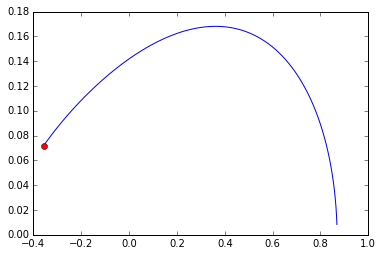

In [97]:
plt.plot([it.constant_cf for it in x],[it.constant_cf for it in v])
plt.plot(x[0].constant_cf, v[0].constant_cf, 'ro')
plt.show()

In [98]:
xf, vf = x[-1], v[-1]

In [99]:
xf.constant_cf

0.86889003396021

In [100]:
vf.constant_cf

0.00835324211160893

# 4 - Studying the effects of the weights on the behavior
We have represented all the robot behavior (x, v) as a polynomial function of the weights. So we now know what happens to the behaviour if we change the weights!! Lets see ... we only consider the final state, but the same can be done for all states before

In [101]:
dweights = dict({'da': -0.01, 'db': 0.01, 'dc': -0.01, 'de': 0.01, 'df': 0.01, 'dg': -0.01})
#Lets predict the new final position of our 'robot' if we change his controller as defined above
print("new xf: {}".format(xf.evaluate(dweights)))
print("new vf: {}".format(vf.evaluate(dweights)))

new xf: 0.5575095882959649
new vf: 0.05315918657381213


# 5 - Check that we learned the correct map
We now simulate again our behavior using the new weights to see where we end up to check if the prediction made after our differential learning is correct.

In [102]:
new_weights = [it + dweights['d' + it.symbol_set[0]] for it in weights] 

In [103]:
new_simulated_x = [x[0]]
new_simulated_v = [v[0]]
dt = 0.1
# We propagate for 10 seconds (cannot oincrease this much as the control is polynomial thus x**2 and v**2 would make u1 biiiig)
for i in range(100):
    dx, dv = eom([new_simulated_x[-1],new_simulated_v[-1]], new_weights)
    new_simulated_x.append(new_simulated_x[-1] + dt * dx)
    new_simulated_v.append(new_simulated_v[-1] + dt * dv)

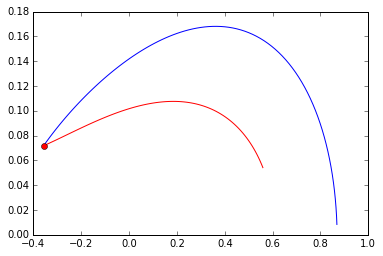

In [104]:
plt.plot([it.constant_cf for it in new_simulated_x],[it.constant_cf for it in new_simulated_v],'r')
plt.plot([it.constant_cf for it in x],[it.constant_cf for it in v])
plt.plot(x[0].constant_cf, v[0].constant_cf, 'ro')
plt.show()

In [105]:
new_simulated_xf, new_simulated_vf = new_simulated_x[-1], new_simulated_v[-1]

In [106]:
new_simulated_xf.constant_cf

0.5593646565391344

In [107]:
new_simulated_vf.constant_cf

0.05417756366340196

In [108]:
print("Differential learning xf: \t{}".format(xf.evaluate(dweights)))
print("Real xf: \t\t\t{}".format(new_simulated_xf.constant_cf))
print("Differential learning vf: \t{}".format(vf.evaluate(dweights)))
print("Real vf: \t\t\t{}".format(new_simulated_vf.constant_cf))

Differential learning xf: 	0.5575095882959649
Real xf: 			0.5593646565391344
Differential learning vf: 	0.05315918657381213
Real vf: 			0.05417756366340196
